## What is ARIMA - Auto Regressive Inegreated Moving Average is a general class of statistical models for time series analysis forecasting


## ARIMA uses a time series past values and / or forecast errors to predict future values

## ARIMA model assumption - stationary: the time series has it's statistical properties that remain constant across time 

## Three compnents/parameters: AR + I + MA (p,d,q)

## AR (Auto Regressive): The time series is linearly regressed on it's own past values
## p: the number of past values that are included in the AR model

## I (Integreated): if not stationary the time series can be differnced to become stationary, compute the differences between consecutive observations
## d: the number of times the time series is differenced

## MA (Moving - Average): the time series is regressed on the past forecast errors
## q: the number of past forecast errors included in the MA model

In [1]:
import pandas as pd 
import numpy as np

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   traffic  393 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


<Axes: >

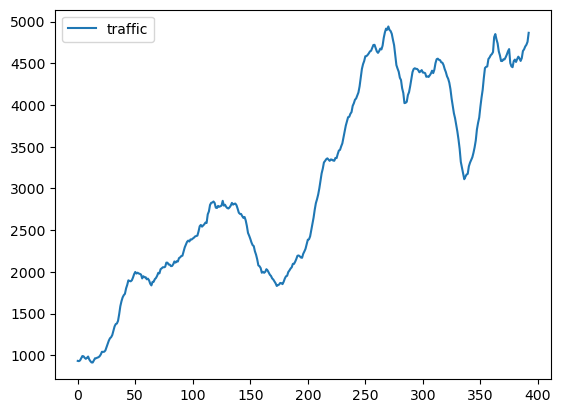

In [4]:
df = pd.read_csv('/Users/macisekander/Downloads/website_data.csv')
df.info()

df.plot()

<Axes: >

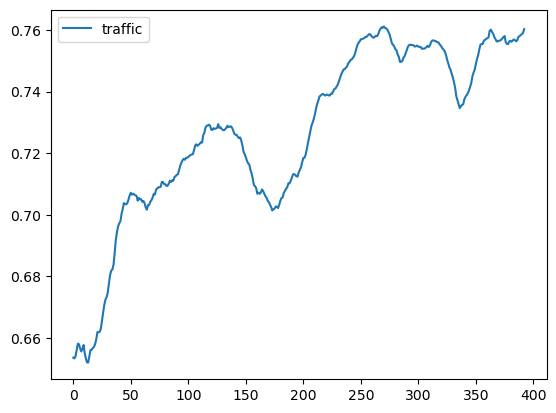

In [7]:
df = np.log(df)# must transform data back when making real predictions
df.plot()

In [8]:
msk = (df.index <len(df)-30)# here we set last 30 data points as test and previous data as training set
df_train = df[msk].copy()
df_test = df[~msk].copy()

# Step 1: Check for stationarity of time series

## Method 1 - check the time series plot (like above the chart is trending upward so not stationary)

## Method 2 - ACF plot and PACF plot

### ACF (autocorrelation function) is the correlation of the time series with it's lags

### PACF (partial autocorrelation function) is the partial correlation of the time series with it's lags, after removing the effects of lower-order-lags between them

### ACF denotes the AutoCorrelation Function plot (sometimes called a Correlogram). PACF denotes the Partial AutoCorrelation Function plot. We will use the ACF and PACF to get a general idea of what models should be used, but let the automatic algorithms do the heavy lifting of determining which model is optimal.


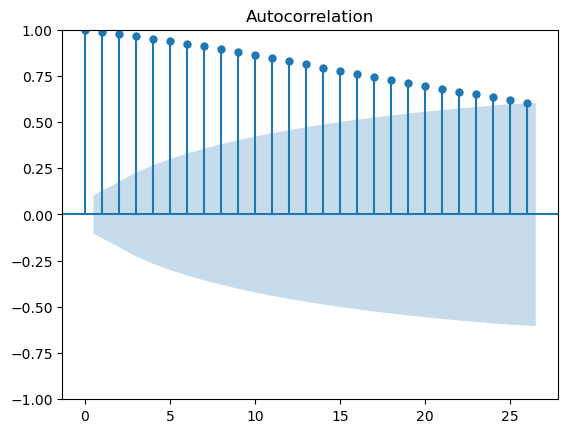

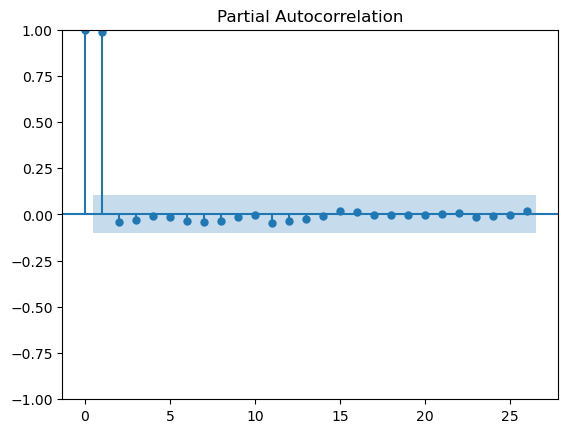

In [9]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

acf_orginal = plot_acf(df_train)# shows that correlation with lags are high and postive with slow decay

pacf_orginal = plot_pacf(df_train)# shows partial autocorrelations at lags 1

## Method 3 - ADF Test
### Tests for null hypothesis: if there is a unit root (non-stationary)

In [13]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_train)
print(f'p-value:{adf_test[1]}')# this result shows a large p-value which means test fails to reject null hypothesis

p-value:0.13779673576540996


# Transform to Stationary: differncing

<Axes: >

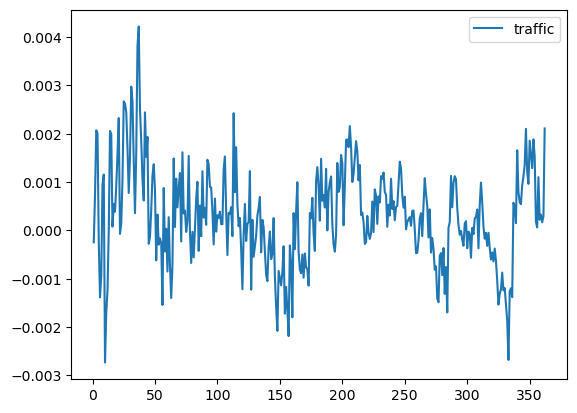

In [14]:
df_train_diff = df_train.diff().dropna()#dropna because first observation has no previous observation to subtract
df_train_diff.plot()#looks more stationary

# acf_diff = plot_acf(df_train_diff)#drops in value more quickly 

pacf_diff = plot_pacf(df_train_diff)#less strong spike at lag 1 

In [20]:
adf_test = adfuller(df_train_diff)
print(f'p-value{adf_test[1]}')#p-value small enough to reject null hypothesis at 5% signficance level

p-value0.01970534493154073


# Step 2: Determine ARIMA models parameters p,q

### if the PACF plot has a signficant spike at lag p, but not beyond; the ACF plot decays more gradually. This may suggest an ARIMA (p,d,0) model. If the ACF plot has a signficant spike at lag q, but not beyond; the PACF plot decays more gradually. This may sugget an ARIMA (0,d,q) model.

# Step 3: Fit the ARIMA model 

In [22]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_train, order =(2,1,0))

model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                  363
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2088.086
Date:                Sun, 05 May 2024   AIC                          -4170.172
Time:                        16:14:10   BIC                          -4158.497
Sample:                             0   HQIC                         -4165.531
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5987      0.047     12.665      0.000       0.506       0.691
ar.L2          0.1328      0.056      2.360      0.018       0.022       0.243
sigma2      5.705e-07   3.12e-08     18.265      0.0

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Step 4: Make time series predictions

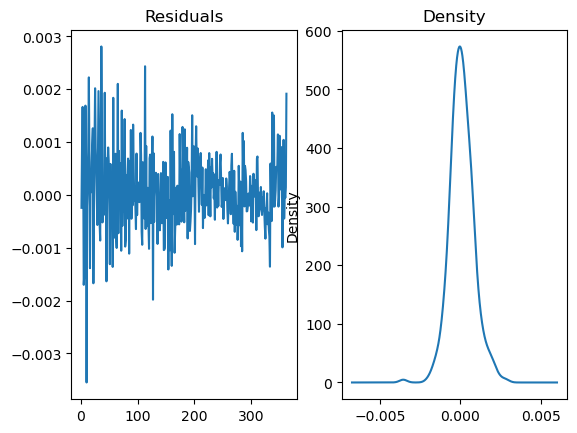

In [25]:
import matplotlib.pyplot as plt

residuals = model_fit.resid[1:]
fig,ax = plt.subplots(1,2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(title = 'Density' , kind = 'kde', ax = ax[1])
plt.show()#residuals look random and general and the density normal distribution with a mean around 0

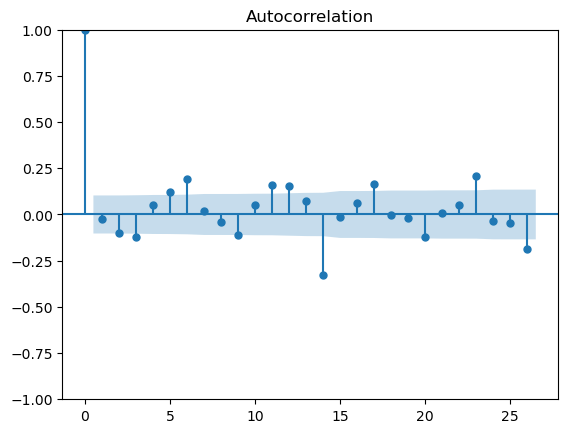

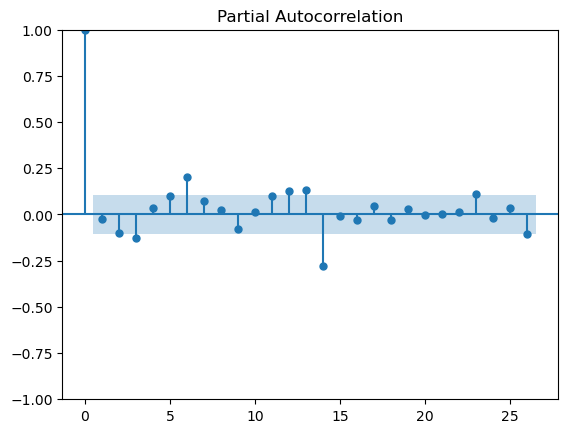

In [26]:
acf_residuals = plot_acf(residuals)

pacf_residuals = plot_pacf(residuals)

<Axes: >

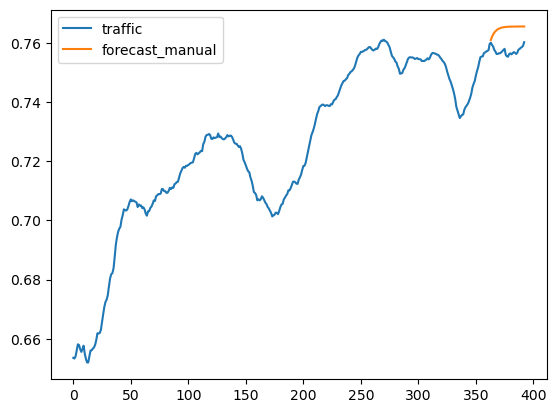

In [27]:
forecast = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train)+list(forecast)

df.plot()#shows upward trend

# Auto fitting the ARIMA model

In [30]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 8.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [33]:
import pmdarima as pm 

auto_arima = pm.auto_arima(df_train,stepwise=False,seasonal=False)
auto_arima# now manually we have ARIMA(2,1,0) and autoARIMA(5,1,0)

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [32]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  363
Model:               SARIMAX(5, 1, 0)   Log Likelihood                2102.915
Date:                Sun, 05 May 2024   AIC                          -4191.829
Time:                        16:23:10   BIC                          -4164.588
Sample:                             0   HQIC                         -4181.000
                                - 363                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.439e-05   4.02e-05      1.352      0.176   -2.45e-05       0.000
ar.L1          0.5236      0.049     10.742      0.000       0.428       0.619
ar.L2          0.0804      0.064      1.249      0.212      -0.046       0.207
ar.L3         -0.0508      0.063     -0.809      0.418      -0.174       0.072
ar.L4          0.1280      0.049      2.609      0.009       0.032       0.224
ar.L5          0.1349      0.045      3.001      0.003       0.047       0.223
sigma2      5.186e-07   3.24e-08     15.988      0.000    4.55e-07    5.82e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                28.98
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Step 5: Evaluate Model Performance

<Axes: >

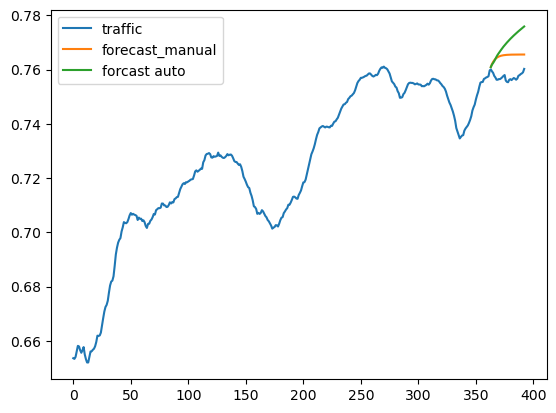

In [37]:
forecast_test_auto = auto_arima.predict(n_periods = len(df_test))
df['forcast auto'] = [None]*len(df_train)+list(forecast_test_auto)

df.plot()#ARIMA(2,1,0) is closer to the test set which is the manual one we created 

In [42]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test,forecast)
mape = mean_absolute_percentage_error(df_test,forecast)
mse = mean_squared_error(df_test,forecast)

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'mse - manual: {mse}')#manually fitted model better with lower errors

mae - manual: 0.007603837255582032
mape - manual: 0.010044538992058826
mse - manual: 6.208473006044494e-05


In [43]:

mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
mse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'mse - auto: {mse}')

mae - auto: 0.01227843913890749
mape - auto: 0.01621652762460611
mse - auto: 0.013126583881986217
